In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../')

from utils.data_processing import EyeTrackingProcessor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

****
# Data Processing
****

In [2]:
path_001 = 'data/Project1 Data export raw_001.tsv'
path_002 = 'data/Project1 Data export raw_002.tsv'
path_003 = 'data/Project1 Data export raw_003.tsv'
path_004 = 'data/Project1 Data export raw_004.tsv'
path_005 = 'data/Project1 Data export raw_005.tsv'
path_006 = 'data/Project1 Data export raw_006.tsv'
path_007 = 'data/Project1 Data export raw_007.tsv'
path_008 = 'data/Project1 Data export raw_008.tsv'
path_list = [path_001, path_002, path_003, path_004, path_005, path_006, path_007, path_008]

tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
features = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Participant name']
interpolate_col = ['Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y']

processor = EyeTrackingProcessor(chunk_duration=5*1e6, time_offset_chunk=0.5*1e6, target_size=600)
all_data = processor.load_data(path_list)
dataset = processor.get_features(all_data, tasks, features)
dataset = processor.get_chunks(dataset)
dataset_resampled = processor.process_and_resample_all(dataset, interpolate_col)

c:\Users\kruu\git_folder\eye_tracking\utils\data_processing.py:11: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')


Only Nans for participant 7, task 3, execution 3, chunk 0
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 3, execution 3, chunk 1
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 3, execution 3, chunk 2
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 3, execution 3, chunk 3
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 3, execution 3, chunk 4
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 3, execution 3, chunk 5
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 3, execution 3, chunk 6
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 5, execution 5, chunk 0
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 5, execution 5, chunk 1
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 5, execution 5, chunk 2
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 5, execution 5, chunk 3
['Gaze point X', 'Gaze

In [ ]:
# Verification of chunk durations
#Some chunks are way longer or way shorter than 5 seconds -> we have to findout why
test = dataset.groupby(['Participant name', 'Task_id', 'Task_execution', 'chunk_id'])["Recording timestamp"].agg(lambda x: (x.max() - x.min())/1e6)
test.describe()

count    7600.000000
mean        4.990253
std         0.046424
min         3.239643
25%         4.991491
50%         4.991501
75%         4.992024
max         4.999991
Name: Recording timestamp, dtype: float64

In [17]:
dataset_resampled.isna().sum()

Gaze point X        0
Gaze point Y        0
Mouse position X    0
Mouse position Y    0
chunk_id            0
Participant name    0
Task_id             0
Task_execution      0
dtype: int64

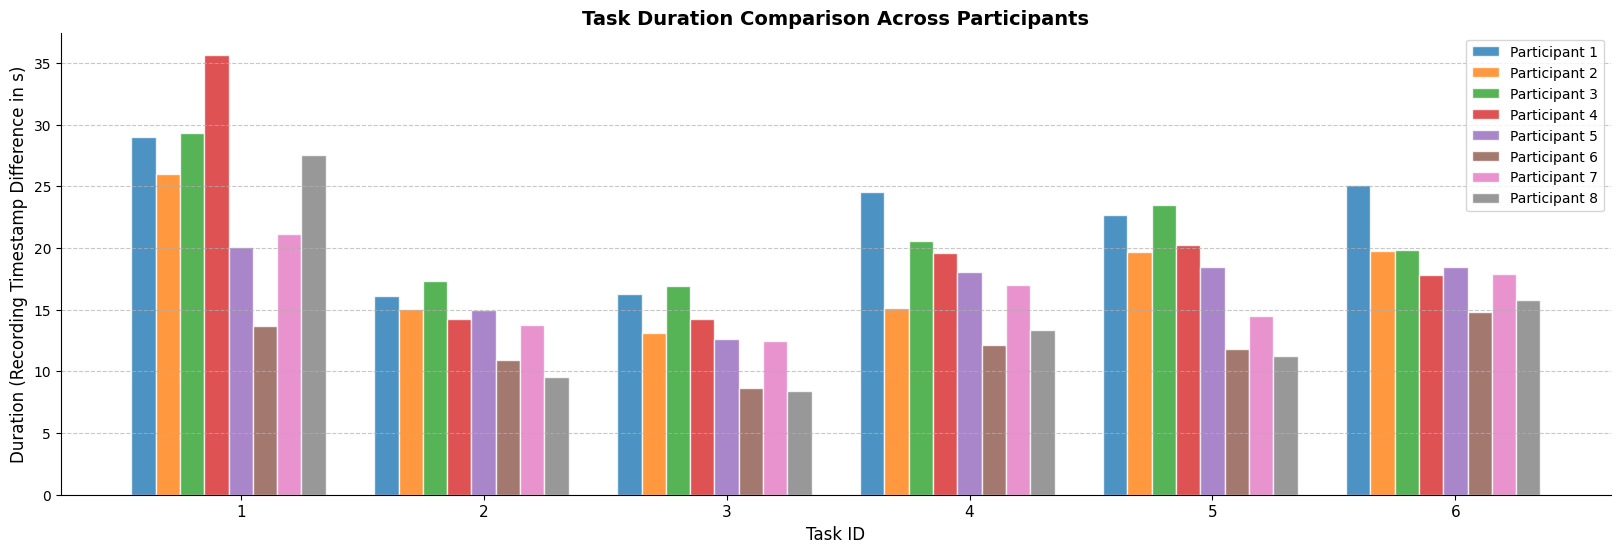

In [20]:
import matplotlib.colors as mcolors

durations = pd.DataFrame(dataset.groupby(['Participant name', 'Task_id', 'Task_execution'])['Recording timestamp'].agg(lambda x: (x.max() - x.min())/1e6).reset_index().groupby(['Participant name', 'Task_id'])['Recording timestamp'].mean()).reset_index()

plt.figure(figsize=(20, 6))
pastel_colors = list(mcolors.TABLEAU_COLORS.values())
bar_width = 0.1
task_ids = sorted(durations["Task_id"].unique())
participants = sorted(durations["Participant name"].unique())
x_indexes = np.arange(len(task_ids))

# Plot bars for each participant
for i, participant in enumerate(participants):
    participant_data = durations[durations["Participant name"] == participant]
    plt.bar(x_indexes + i * bar_width, participant_data["Recording timestamp"], 
            width=bar_width, color=pastel_colors[i % len(pastel_colors)], 
            edgecolor='white', alpha=0.8, label=f'Participant {participant}')

# Formatting
plt.xlabel("Task ID", fontsize=12)
plt.ylabel("Duration (Recording Timestamp Difference in s)", fontsize=12)
plt.title("Task Duration Comparison Across Participants", fontsize=14, fontweight='bold')

plt.xticks(x_indexes + (bar_width * (len(participants) / 2)), task_ids, fontsize=11) 

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(fontsize=10)

plt.show()


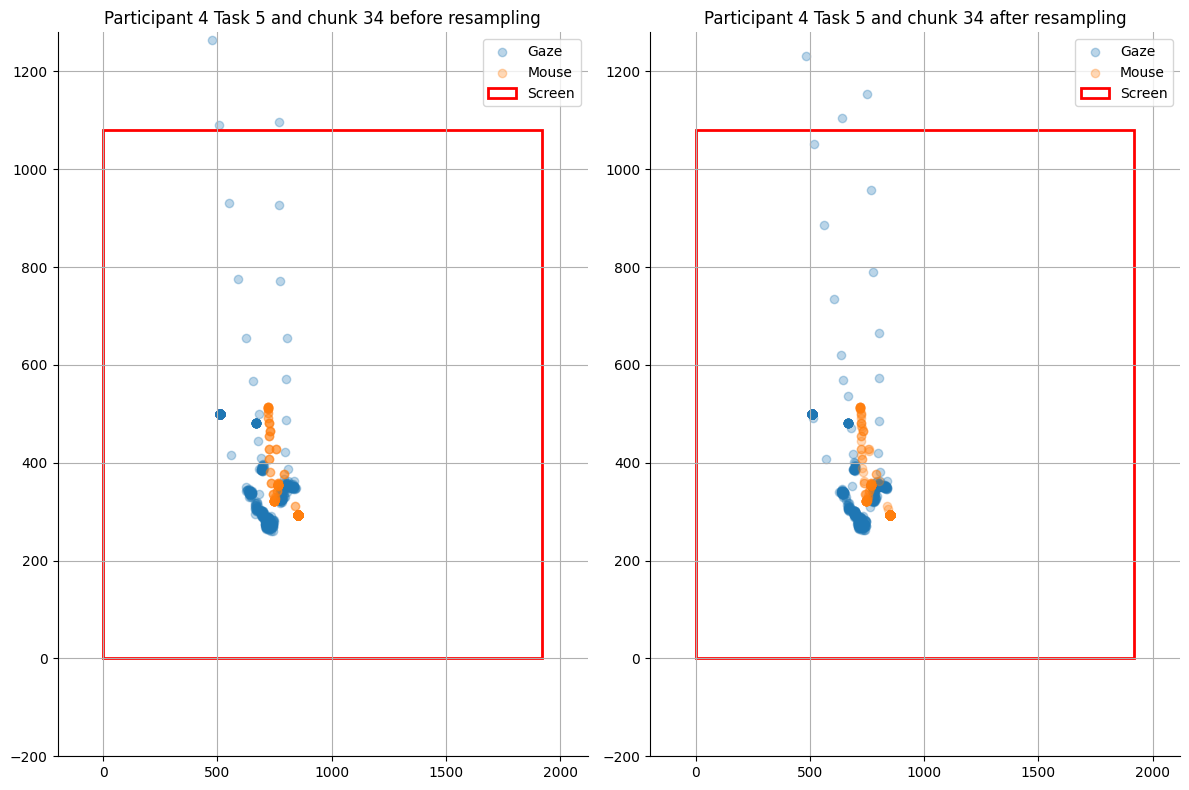

In [21]:
# Comparision of chunks before and after resampling
participant = np.random.choice(dataset["Participant name"].unique())
task_id = np.random.choice(dataset["Task_id"].unique())
task_execution = np.random.choice(dataset["Task_execution"].unique())
data_plot = dataset.query(f"`Participant name` == {participant} and Task_id == {task_id} and Task_execution == {task_execution}")
chunk_id = np.random.choice(data_plot["chunk_id"].dropna().unique())
data_plot_initial = data_plot.query(f"chunk_id == {chunk_id}")
data_plot_resampled = dataset_resampled.query(f"`Participant name` == {participant} and Task_id == {task_id} and Task_execution == {task_execution} and chunk_id == {chunk_id}")

fig, axes = plt.subplots(1, 2, figsize=(12, 8)) 
axes = axes.flatten()
axes[0].scatter(data_plot_initial["Gaze point X"], data_plot_initial["Gaze point Y"], label="Gaze", alpha=0.3)
axes[0].scatter(data_plot_initial["Mouse position X"], data_plot_initial["Mouse position Y"], label="Mouse", alpha=0.3)
axes[0].set_title(f"Participant {participant} Task {task_id} and chunk {chunk_id} before resampling")
axes[0].add_patch(plt.Rectangle((0, 0), 1920, 1080, fill=None, color='r', linewidth=2, label="Screen"))
axes[0].legend()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].grid(True)
axes[0].set_xlim(-200, 2120)
axes[0].set_ylim(-200, 1280)

axes[1].scatter(data_plot_resampled["Gaze point X"], data_plot_resampled["Gaze point Y"], label="Gaze", alpha=0.3)
axes[1].scatter(data_plot_resampled["Mouse position X"], data_plot_resampled["Mouse position Y"], label="Mouse", alpha=0.3)
axes[1].set_title(f"Participant {participant} Task {task_id} and chunk {chunk_id} after resampling")
axes[1].add_patch(plt.Rectangle((0, 0), 1920, 1080, fill=None, color='r', linewidth=2, label="Screen"))
axes[1].legend()
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].grid(True)
axes[1].set_xlim(-200, 2120)
axes[1].set_ylim(-200, 1280)


plt.tight_layout()
plt.show()

****
# Model Training
****

First idea:
- One sample is 600 observations, for one participant, one task, and one chunk_id
- Label is task_id
- First we will work on aggregated features like min/max/mean/std to see if they are sufficient to predict. If not we will use the full time series and train an LSTM of whatever. 
- Try using multi-head 2D CNN: one for gazeX/Y and another one for MouseX/Y

In [22]:
#If the gaze or mouse is outside the screen, we replace the value with -9999
placeholder_value = np.nan
train_dataset = processor.outside_screen_placeholder(dataset_resampled, [-200, 2120], [-200, 1280], placeholder_value)

# We can add a missingness Indicator Feature
# for col in features:
#     dataset[col + "_missing"] = (dataset[col] == placeholder_value).astype(int)

In [23]:
def flatten_group(group):
    return np.concatenate([
        group['Gaze point X'].values,
        group['Gaze point Y'].values,
        group['Mouse position X'].values,
        group['Mouse position Y'].values
    ])

# Grouping by participant, task, execution, and chunk
grouped_data = train_dataset.groupby(['Participant name', 'Task_id', 'Task_execution', 'chunk_id']).apply(flatten_group)

# Flatten column names after aggregation
flattened_df = grouped_data.reset_index()
flattened_df.columns = ['Participant name', 'Task_id', 'Task_execution', 'chunk_id', 'flattened_features']

# Extract features (X) and labels (y)
X = np.vstack(flattened_df['flattened_features'].values)
y = flattened_df['Task_id'].values

# Train/test split (WARNING: split before if using time series data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\kruu\AppData\Local\Temp\ipykernel_20352\3585948980.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_data = train_dataset.groupby(['Participant name', 'Task_id', 'Task_execution', 'chunk_id']).apply(flatten_group)


In [24]:
scaler = MinMaxScaler()

# MinMaxScaler automatically keep nans out of scaling
# We can also set ourselves the values of MinMax with the screen limits
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Replace nans with -1 after scaling: they are indicating outside of the screen
X_train_scaled = np.where(np.isnan(X_train_scaled), -1, X_train_scaled)
X_test_scaled = np.where(np.isnan(X_test_scaled), -1, X_test_scaled)


In [25]:
# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear']  # Kernel type
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
print(best_params)

# Train SVM
svm_model = SVC(kernel=best_params["kernel"], C=best_params["C"], gamma=best_params["gamma"])
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(classification_rep)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


KeyboardInterrupt: 

Ideas to implement:
- Maybe explore an algorithm that is based on the full task and try to recognise if what he is observing is a bit of the full task. Find a way to represent the "average pattern" for each task and then build a model that recognise that each chunk is a part of this pattern -> Sub timeseries classification.
- Instead of having distinct chunks, we can have overlapping training samples (just like we do for MIAR).